# Project Flow:
#1. Loading the dataset
#2. Visualize the images
#3. Data Augmentation
#4. Train Test Split
#5. Building the EfficientNet model
#6. Prediction and Evaluation

#1. Loading the dataset


In [2]:
!pip install --upgrade imgaug

In [4]:
!pip install --upgrade numpy
!pip install --upgrade imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [1]:
!pip install numpy==1.26.4
!pip install --upgrade imgaug
# importing libraries
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# this command is used to tell the system that a kaggle.json file is there to be used in this env baiscally for
#file identification
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle


cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d imsparsh/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 91% 186M/205M [00:02<00:00, 81.8MB/s]
100% 205M/205M [00:02<00:00, 86.9MB/s]


In [4]:
zip_ref = zipfile.ZipFile('/content/flowers-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
data_dir = '/content/flowers'  #base directory
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#2. Visualize the images

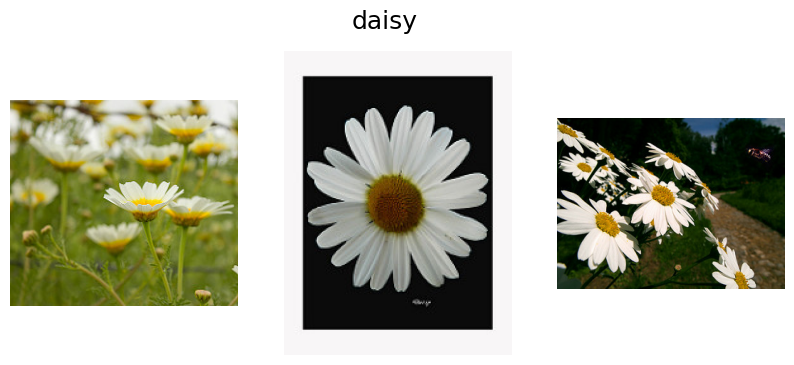

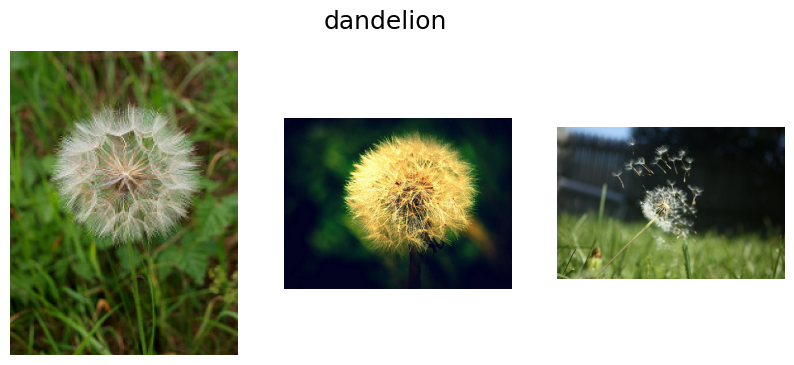

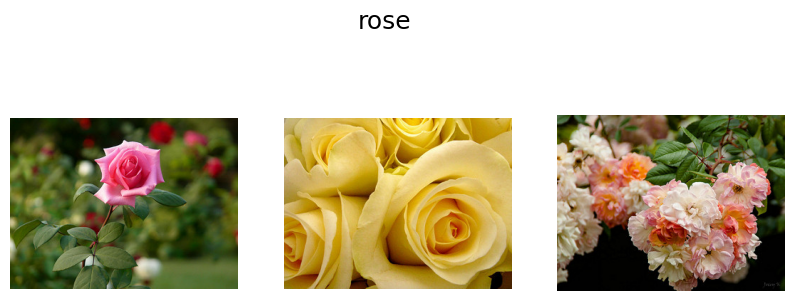

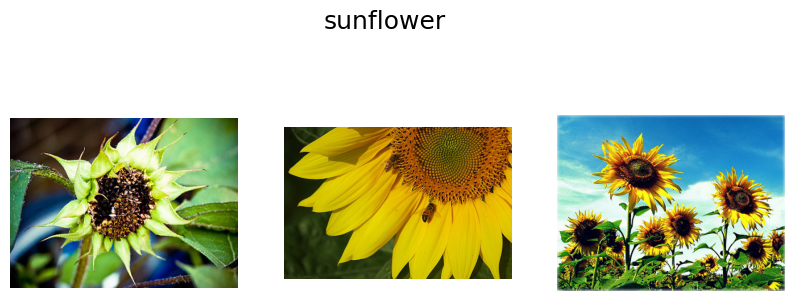

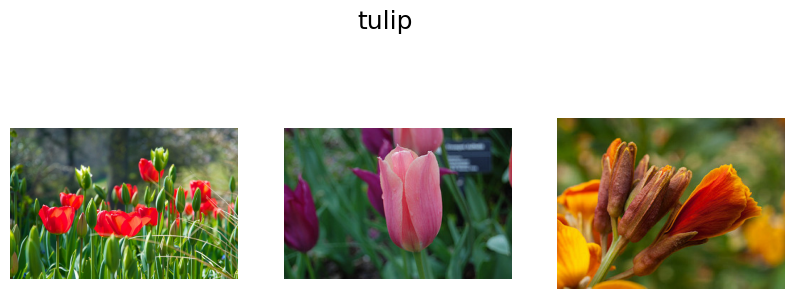

In [7]:
# visulaizing the images
for catgo in categories:
  #constructing the path
  path = os.path.join(data_dir, catgo)
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize = (10, 4))
  fig.suptitle(f'{catgo}', fontsize = 18)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    # converting the BGR images to RGB beacuse matplotlib read images in rgb but cv2 read it in bgr that's why
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb)
    ax[i].axis('off')

#3. Data Augmentation


In [8]:
def count_images(directory):
  for catgo in categories:
    path = os.path.join(directory, catgo)
    images = os.listdir(path)
    num_images = len(images)
    print(f'{catgo} : {num_images} images')

count_images(data_dir)


daisy : 501 images
dandelion : 646 images
rose : 497 images
sunflower : 495 images
tulip : 607 images


In [9]:
#here we applyied data augmentation and we will check the previous count and after augmentation count
# data augmentati
aug = iaa.Sequential([
    #horizontal flips
    iaa.Fliplr(0.5),
    # randomly croping images upto 10% os it's size
    iaa.Crop(percent = (0, 0.1)),
    # scaling the image between 80% and 120% and rotating it between -25 to 25
    iaa.Affine(scale = (0.8, 1.2), rotate = (-25, 25)),
    # changin the brightness of the images
    iaa.Multiply((0.8, 1.2)),
    # adjusting the contrast of the images
    iaa.LinearContrast((0.75, 1.5))
])

def augment_images(directory, categories):
  for catgo in categories:
    path = os.path.join(directory, catgo)
    for filename in os.listdir(path):
      img = cv2.imread(os.path.join(path, filename))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      augmented_img = aug.augment_image(img)

      new_filename = os.path.splitext(filename)[0] + '_augmented' + os.path.splitext(filename)[1]
      cv2.imwrite(os.path.join(path, new_filename), augmented_img)

augment_images(data_dir, categories)

In [10]:
count_images(data_dir)

daisy : 1002 images
dandelion : 1292 images
rose : 994 images
sunflower : 990 images
tulip : 1214 images


In [11]:
img_array.shape #effecientnet require img size to be 244x244

(240, 320, 3)

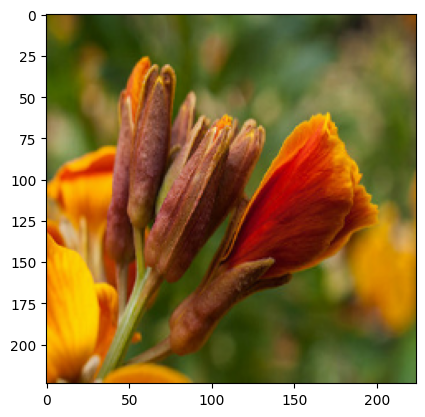

In [12]:
# resizing images
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#4. Train Test Split


In [13]:
# creating training data
training_data = []

def create_training_data():
  for catgo in categories:
    path = os.path.join(data_dir, catgo)
    labels = categories.index(catgo)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

create_training_data()

In [14]:
len(training_data)

5492

In [15]:
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

In [16]:
type(X), type(y)#data is in list but for TL format its necessary to be in array

(list, list)

In [17]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [18]:
# train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [19]:
print(f'X_train length : {X_train.shape[0]}, X_train Image Size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test length : {X_test.shape[0]}, X_test Image Size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')


X_train length : 4393, X_train Image Size : (224, 224), Channel Dimension : 3
X_test length : 1099, X_test Image Size : (224, 224), Channel Dimension : 3


#5. Building the EfficientNet model


In [20]:
efficient_net = EfficientNetB0(weights = 'imagenet',
                               include_top = False,
                               input_shape = (IMG_SIZE, IMG_SIZE, 3))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# freezing the bottom layers
for layer in efficient_net.layers:
  layer.trainable = False

In [22]:

# constructing the FC(Dense) layers
model = keras.Sequential([
    efficient_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(5, activation = 'softmax'),#for multiclass classification always use softmax and for binary use sigmoid
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 10, batch_size = 64)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.7476 - loss: 0.6254
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9546 - loss: 0.1402
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9724 - loss: 0.0821
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9793 - loss: 0.0612
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9874 - loss: 0.0389
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9778 - loss: 0.0567
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9882 - loss: 0.0337
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9889 - loss: 0.0336
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9883 - loss: 0.0323
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9917 - loss: 0.0263


In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.9259 - loss: 0.3701
Model Accuracy : 91.17379188537598


In [24]:
pred = np.argmax(model.predict(X_test), axis = -1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step


In [25]:
pred

array([4, 0, 2, ..., 0, 1, 4])

In [26]:
y_test[:5]

array([4, 0, 2, 1, 4])

In [27]:
pred[:5]

array([4, 0, 2, 1, 4])

In [28]:
y_test[10:20]

array([1, 4, 3, 1, 3, 3, 0, 4, 1, 3])

In [29]:
pred[10:20]

array([1, 4, 3, 1, 3, 3, 0, 4, 1, 3])

In [30]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       214
           1       0.95      0.93      0.94       256
           2       0.80      0.92      0.85       182
           3       0.90      0.95      0.92       187
           4       0.95      0.86      0.90       260

    accuracy                           0.91      1099
   macro avg       0.91      0.91      0.91      1099
weighted avg       0.92      0.91      0.91      1099



Text(50.722222222222214, 0.5, 'ACTUAL')

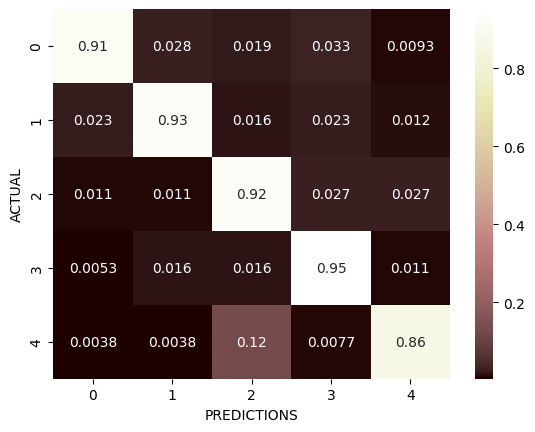

In [34]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'pink');
plt.xlabel('PREDICTIONS')
plt.ylabel('ACTUAL')